--- 
format: html
echo: False
---
# InsideAirbnb - London 

### Questions discussed in this report: 
1. Is Airbnb “out of control” in London?

    - Yes, we will answer this question through illegal, housing market, and Airbnb density aspects.

  
2. How many professional landlords are there?

    - Professional landlords are landlord with listing counts greater than or equal to 1 with the listing room type of "entire" or "hotel".

3. How many properties would be affected by the opposition’s proposal?

    - direct effects: illegal properties and professional properties
    - indirect effects: all properties
     
   (need to explain the mechanism of effect on properties in this question)

    - further: how would the effects be (discussed in question 4)
    - question: what kind of effects they could be? only negative or negative & positive?

4. What are the likely pros and cons of the opposition’s proposal? (for the Mayor, for the residents, for the city)

5. Can the story be reframed as a positive one about social mobility or housing opportunity?


In [ ]:
# 1. EDA

# # 1.0. Caching Remote Data

In [ ]:
#| output: False

# Import libraries needed for this analysis
from pathlib import Path
from requests import get
from functools import wraps
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches

import matplotlib
import matplotlib.font_manager

In [ ]:
#| output: False

def check_cache(f):
    @wraps(f)
    def wrapper(src:str, dst:str, min_size=100) -> Path:
        url = Path(src) 
        fn  = url.name  
        dsn = Path(f"{dst}/{fn}") 
        if dsn.is_file() and dsn.stat().st_size > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:Path, dst:Path) -> str:
    """Downloads a remote file.
    
    
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
      
    # Create...
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        
    # Download and write the file
    with dst.open(mode='wb') as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst.resolve()

In [ ]:
# ### 1.1. Data Loading

# #### 1.1.0 Read Data

# In this section, we read data remotely with the caching function above.

In [ ]:
#| output: False

# Set download URL
ymd  = '20250615'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-{city}-listings.csv.gz'

# Read csv data
df = pd.read_csv(url, compression='gzip', low_memory=False)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 96,651 x 79


In [ ]:
# #### 1.1.1 Save Raw Data
# Then, we want to save the raw Data in case we need them again in the later exploring.

In [ ]:
#| output: False

# Create a diractory for raw data
path = Path(f'data/raw/{Path(url).name}') 
print(f"Writing to: {path}")

# Save raw data locally
if not path.parent.exists(): 
    print(f"Creating {path.parent}")
    path.parent.mkdir(parents=True, exist_ok=True)

if not path.exists():  
    df.to_csv(path, index=False)
    print("Done.")

Writing to: data/raw/20250615-London-listings.csv.gz


In [ ]:
# ### 1.2 EDA - Data Processing

# #### 1.2.0. Info

# We run the chunk below to have a general sense of what are in the raw data, such as data type and columns.

In [ ]:
#| output: False

# Get the information of the whole data set
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96651 entries, 0 to 96650
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            96651 non-null  int64  
 1   listing_url                                   96651 non-null  object 
 2   scrape_id                                     96651 non-null  int64  
 3   last_scraped                                  96651 non-null  object 
 4   source                                        96651 non-null  object 
 5   name                                          96651 non-null  object 
 6   description                                   93806 non-null  object 
 7   neighborhood_overview                         41983 non-null  object 
 8   picture_url                                   96642 non-null  object 
 9   host_id                                       96651 non-null 

In [ ]:
#| output: False

df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,9.665100e+04,9.665100e+04,9.665100e+04,96613.000000,96613.000000,0.0,96651.000000,96651.000000,96651.000000,62730.000000,...,71443.000000,71466.000000,71442.000000,71442.000000,0.0,96651.000000,96651.000000,96651.000000,96651.000000,71487.000000
mean,6.526020e+17,2.025061e+13,2.091790e+08,46.263577,76.334945,NaN,51.509818,-0.127087,3.316520,1.358018,...,4.792937,4.816368,4.733591,4.623804,NaN,16.389370,14.170831,2.164716,0.025763,0.958877
std,5.708808e+17,0.000000e+00,2.141266e+08,357.645418,561.614957,NaN,0.048945,0.100853,2.073674,0.725580,...,0.431668,0.423297,0.408804,0.506245,NaN,53.299577,52.845630,8.543681,0.626042,1.282595
min,1.391300e+04,2.025061e+13,2.594000e+03,1.000000,1.000000,NaN,51.295937,-0.496760,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.955518e+07,2.025061e+13,2.673176e+07,1.000000,1.000000,NaN,51.484240,-0.189060,2.000000,1.000000,...,4.760000,4.800000,4.650000,4.500000,NaN,1.000000,0.000000,0.000000,0.000000,0.150000
50%,8.123206e+17,2.025061e+13,1.128684e+08,2.000000,3.000000,NaN,51.513791,-0.126990,2.000000,1.000000,...,4.930000,4.970000,4.850000,4.750000,NaN,2.000000,1.000000,0.000000,0.000000,0.500000
75%,1.197378e+18,2.025061e+13,4.063762e+08,9.000000,14.000000,NaN,51.539099,-0.067880,4.000000,1.500000,...,5.000000,5.000000,5.000000,4.950000,NaN,8.000000,5.000000,1.000000,0.000000,1.230000
max,1.439673e+18,2.025061e+13,7.001298e+08,4884.000000,8723.000000,NaN,51.682630,0.278960,16.000000,26.000000,...,5.000000,5.000000,5.000000,5.000000,NaN,495.000000,495.000000,116.000000,25.000000,38.410000


In [ ]:
# After exploring the meaninig of each column, we selected few columns of interest `cols_selected` for this analysis, by copying the output of (`df.columns.to_list()`) and removed the fields that we thought we weren’t interested in.

# From here, we will use the data set `df` with selected 30 columns.

In [ ]:
#| output: False

df.columns.to_list()
cols_selected = ['id', 'listing_url', 'source', 'description', 'host_id', 'host_name', 'host_is_superhost',
                'host_listings_count', 'calculated_host_listings_count', 
                 'room_type', 'property_type','accommodates', 'bedrooms', 
                 'beds', 'price', 'minimum_nights','maximum_nights',
                'estimated_occupancy_l365d', 'number_of_reviews', 'number_of_reviews_ltm', 'reviews_per_month',
                'review_scores_rating', 'latitude', 'longitude', 'neighbourhood_cleansed', 
                'host_total_listings_count', 'bathrooms', 'bathrooms_text', 
                'first_review', 'last_review']

In [ ]:
#| output: False

# Get a new df with selected cols
df = df[cols_selected]
print(f"The new data frame is {df.shape[0]:,} x {df.shape[1]}")

The new data frame is 96,651 x 30


In [ ]:
# #### 1.2.2. Dealing with NaNs and Nulls

# Combined with results from `df.info()` and `df.describe()`, we see that a number of data types that aren’t ‘appropriate’ for their contents: the id columns are floats; the dates aren’t dates; there’s a boolean that’s not a boolean… It would be nice to fix these!

# We started from exploring rows with NaN values. We checked columns `id` and `host_id`, which are important for us to log information for each host, and we removed any potential rows with missing values in these columns.

# For the remaining data, we checked both by rows and columns. After counting NaNs or Nulls separately, the results showed that it is sensible to retain all columns we selected.

In [ ]:
#| output: False

# Drop NaN
print(f"Data frame contains {df.shape[0]:,} rows.")
df.drop(df[df.host_id.isna()].index.array, axis=0, inplace=True)
print(f"Data frame contains {df.shape[0]:,} rows.")

Data frame contains 96,651 rows.
Data frame contains 96,651 rows.


In [ ]:
#| output: False

# counts nulls by column 
df.isnull().sum(axis=0) 
# Sort results in descending order
df.isnull().sum(axis=0).sort_values(ascending=False) 

# counting nulls by row
df.isnull().sum(axis=1).sort_values(ascending=False).head(10)

4622     11
3646     11
6122     11
5535     11
5155     11
187      10
232      10
683      10
82       10
35147    10
dtype: int64

In [ ]:
# #### 1.2.3. Fix Data Types

# In this section, we are correcting data types that did not match the interpretation.

# In the last part of this section, we created a new column `bathrooms_new` from column `bathrooms_text`, because even the majority of data from `bathrooms` mathes with the data in `bathrooms_text`, there are still many missing values. Therefore, we created a new column and checked the accuracy comparing two columns. 

In [ ]:
#| output: False

# Boolean
bools = ['host_is_superhost']
for b in bools:
    print(f"Converting {b}")
    df[b] = df[b].replace({'f':False, 't':True}).astype('bool')

# Date
dates = ['first_review','last_review']
print(f"Currently {dates[1]} is of type '{df[dates[1]].dtype}'", "\n")
for d in dates:
    print("Converting " + d)
    df[d] = pd.to_datetime(df[d])

print(f"Now {dates[1]} is of type '{df[dates[1]].dtype}'", "\n")

# categories
cats = ['property_type','room_type']
print(f"Currently {cats[1]} is of type '{df[cats[1]].dtype}'", "\n")
for c in cats:
    print(f"Converting {c}")
    df[c] = df[c].astype('category')
print(f"Currently {cats[1]} is of type '{df[cats[1]].dtype}'", "\n")

# strings
money = ['price']
for m in money:
    print(f"Converting {m}")
    df[m] = df[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting host_is_superhost
Currently last_review is of type 'datetime64[ns]' 

Converting first_review
Converting last_review
Now last_review is of type 'datetime64[ns]' 

Currently room_type is of type 'object' 

Converting property_type
Converting room_type
Currently room_type is of type 'category' 

Converting price


In [ ]:
#| output: False

# string
df["bathrooms_text"].unique()
df["bathrooms_text"] = df["bathrooms_text"].replace({
    "Shared half-bath": "0.5 shared baths",
    "Half-bath": "0.5 baths",
    "Private half-bath": "0.5 baths"
})
df["bathrooms_text"] = df["bathrooms_text"].astype(str)
df["bathrooms_text"] = (
    df["bathrooms_text"]
        .str.split(" ", n=1).str[0]
        .astype(float)
)
print("bathrooms null:", df["bathrooms"].isnull().sum())
print("bathrooms_text null:", df["bathrooms_text"].isnull().sum())

df = df.drop(columns=['bathrooms'])
df.rename(columns={'bathrooms_text': 'bathrooms_new'}, inplace=True)

# col types
ints = ['id', 'host_id',
        'host_listings_count', 
        'accommodates', 'bedrooms', 'beds', 'minimum_nights','maximum_nights',
        'estimated_occupancy_l365d', 'number_of_reviews_ltm', 'reviews_per_month',
        'host_total_listings_count', 'bathrooms_new', 'calculated_host_listings_count']

print(df[ints].dtypes)

bathrooms null: 33921
bathrooms_text null: 149
id                                  int64
host_id                             int64
host_listings_count               float64
accommodates                        int64
bedrooms                          float64
beds                              float64
minimum_nights                      int64
maximum_nights                      int64
estimated_occupancy_l365d           int64
number_of_reviews_ltm               int64
reviews_per_month                 float64
host_total_listings_count         float64
bathrooms_new                     float64
calculated_host_listings_count      int64
dtype: object


In [ ]:
# ### 1.3 Saving Clean Data

In [ ]:
#| output: False

csv_out = Path(f'data/clean/{path.name}')
pq_out  = Path(f'data/clean/{path.name.replace('.csv.gz','.parquet')}')

if not csv_out.parent.exists():
    print(f"Creating {csv_out.parent}")
    csv_out.parent.mkdir(parents=True, exist_ok=True)
    
df.to_csv(csv_out, index=False)
df.to_parquet(pq_out, index=False)
print(f"Saved {df.shape[0]:,} rows of {df.shape[1]:,} columns to {csv_out.resolve()}")
print("Done.")

Saved 96,651 rows of 29 columns to /home/jovyan/work/data/clean/20250615-London-listings.csv.gz
Done.


### Question 1: Airbnb in London is out of control.

We argue that Airbnb in London is out of control from three aspects:

1. The density of Airbnb in London is not "normal", especially when comparing listings between inner and outer London.
2. Airbnb is a key driver of housing stock reduction in London, which negatively impacts the supply of long-term housing rent.
3. Airbnb caused the increase of housing price in London, which is arsing the housing crisis in London.

#### 1.1 How do Airbnb listings distribute in London?

We start the analysis from investiagting the situation of Airbnb density in London with a map of the distribution of each type of room.

In [ ]:
#| output: False

# Write data into Geo-data and
# set the crs into '4326'
gdf = gpd.GeoDataFrame(df,
      geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))

# read extra data for mapping
ddir  = Path('data/geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
boros = gpd.read_file( cache_data(spath + 'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath + 'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath + 'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

# match crs for essential data sets as the boros crs
target_crs = boros.crs
gdf = gdf.to_crs(target_crs)
water = water.to_crs(target_crs)
greenspace = green.to_crs(target_crs)

+ data/geo/Boroughs.gpkg?raw=true found locally!
+ data/geo/Water.gpkg?raw=true found locally!
+ data/geo/Greenspace.gpkg?raw=true found locally!
Done.


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Boroughs.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Water.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File data/geo/Greenspace.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(


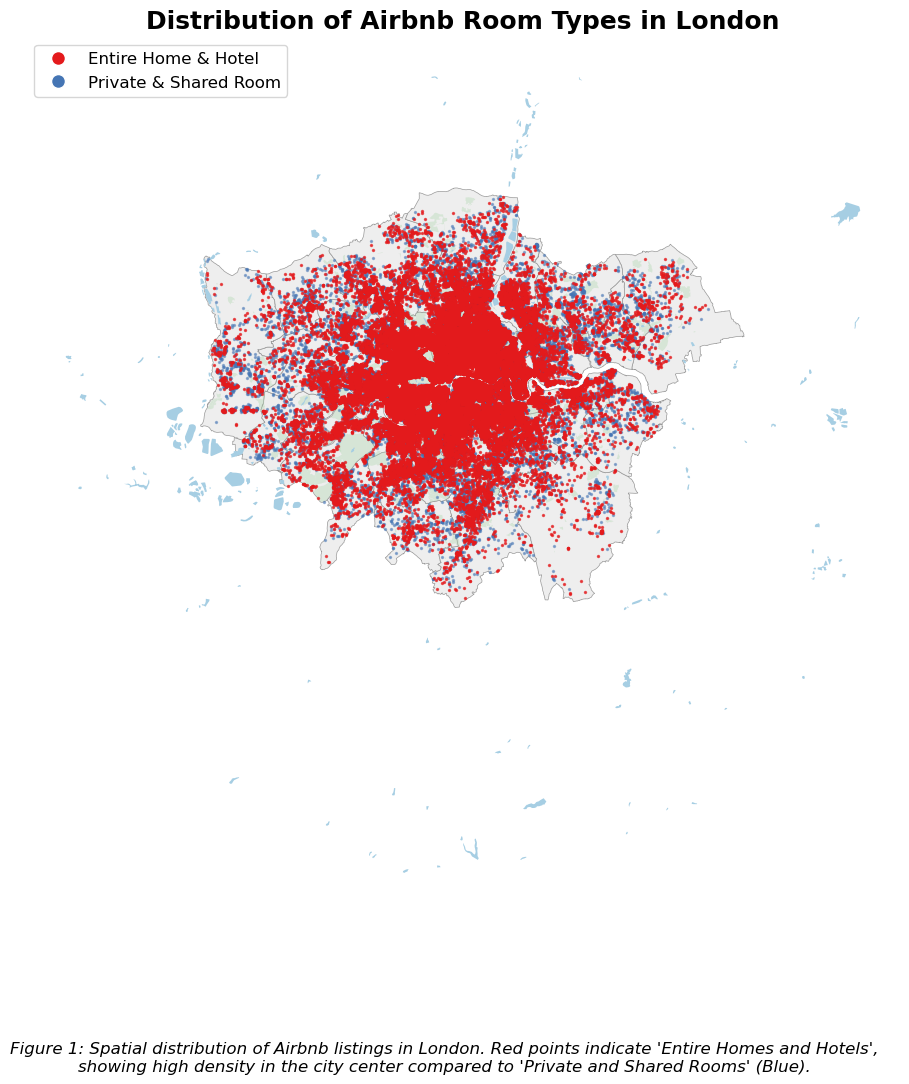

In [84]:
# Distribution map
# Create the Groups
def assign_group(room_type):
    if room_type in ['Entire home/apt', 'Hotel room']:
        return 'Entire Home & Hotel'
    else:
        return 'Private & Shared Room'

gdf['room_group'] = gdf['room_type'].apply(assign_group)

# ==========================================
highlight_color = '#e41a1c'  # Bright Red
secondary_color = '#4575b4'  # Muted Slate Blue (Visible but receding)

# Create the Highlight Map
fig, ax = plt.subplots(figsize=(15, 12))

# --- Plot Background ---
# Made boroughs slightly darker to help the blue pop a bit more
boros.plot(ax=ax, color='#eeeeee', edgecolor='#999999', linewidth=0.5)
green.plot(ax=ax, color='#b2d8b2', alpha=0.4, zorder=1) 
water.plot(ax=ax, color='#a6cee3', zorder=2)

# --- Plot the Groups Manually ---

# GROUP B: The "Secondary" group (Private/Shared)
# Plot FIRST (bottom layer), increased alpha slightly for visibility
non_entire = gdf[gdf['room_group'] == 'Private & Shared Room'].copy()
non_entire.plot(
    ax=ax,
    color=secondary_color, 
    markersize=2,
    alpha=0.5,           # Increased from 0.3 to 0.5 for better visibility
    zorder=3
)

# GROUP A: The "Highlight" group (Entire Homes)
# Plot SECOND (top layer), high alpha
entire = gdf[gdf['room_group'] == 'Entire Home & Hotel'].copy()
entire.plot(
    ax=ax,
    color=highlight_color,    
    markersize=2,       
    alpha=0.7,          
    zorder=4
)
# Custom Legend and Titles
ax.set_title('Distribution of Airbnb Room Types in London', fontsize=18, fontweight='bold')
ax.set_axis_off()
# Update legend colors to match variables
red_dot = mlines.Line2D([], [], color='white', marker='o', markerfacecolor=highlight_color, markersize=10, label='Entire Home & Hotel')
blue_dot = mlines.Line2D([], [], color='white', marker='o', markerfacecolor=secondary_color, markersize=10, label='Private & Shared Room')
plt.legend(handles=[red_dot, blue_dot], loc='upper left', frameon=True, fontsize=12)
# Add the caption
fig.text(
    0.5, 0.02, 
    "Figure 1: Spatial distribution of Airbnb listings in London. Red points indicate 'Entire Homes and Hotels',\nshowing high density in the city center compared to 'Private and Shared Rooms' (Blue).", 
    ha='center',       # Horizontal alignment: center
    fontsize=12,       # Size of the text
    color='black',     # Color
    style='italic',    # Style (optional)
    wrap=True          # wrap text if it's too long
)
# Adjust the margin
plt.subplots_adjust(bottom=0.15)
plt.show()

Figure 1 shows a significant disparity in listings between "Entire Homes/Apt and Hotels Rooms" and "Private and Shared rooms" in London. This trend is particularly pronounced in central London (Zones 1 and 2) where the dense clustering of red dots suggests that Airbnb is a short-term commercial rental market rather than a platform for sharing spare bedrooms under the "sharing economy". This is contrary to the objectives of the Deregulation Act 2015 which aims to support residents rather than provide opportunities for the commercial sector.

+ data/airbnb/RM204-2021-1-filtered-2025-12-02T17-06-33Z.csv found locally!
Done.


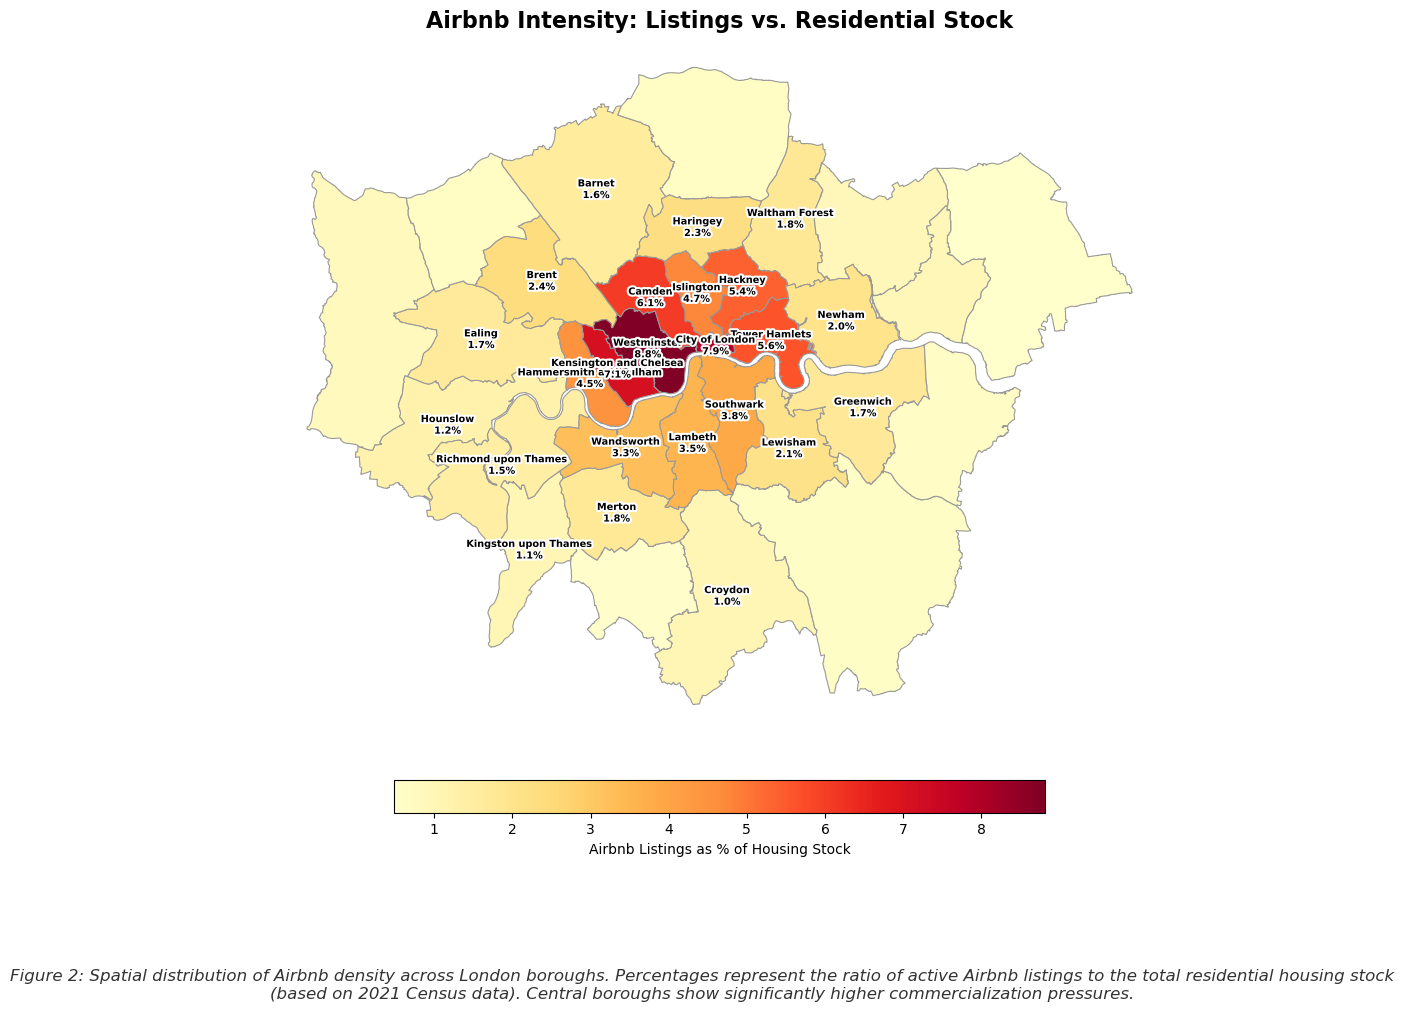

In [80]:
# Density Map
# 1. Load Data
ddir_2 = Path('data/airbnb')
spath_2 = 'https://raw.githubusercontent.com/JianlingZhao/fsds_Airbnb_dwelling_data/main/'
dwl  = pd.read_csv( cache_data(spath_2 + 'RM204-2021-1-filtered-2025-12-02T17-06-33Z.csv', ddir_2) )
print(('Done.'))

dwl = dwl.rename(columns={'Lower tier local authorities': 'NAME', 'Observation': 'total_dwellings'})
# Spatial Join & Counts
joined = gpd.sjoin(gdf, boros, how="inner", predicate="within")
airbnb_counts = joined.groupby('NAME').size().reset_index(name='airbnb_count')

# 2. Merge for Density Calculation
borough_stats = boros.merge(airbnb_counts, on='NAME', how='left')
borough_stats = borough_stats.merge(dwl[['NAME', 'total_dwellings']], on='NAME', how='left')

# Calculate Density
borough_stats['density_pct'] = (borough_stats['airbnb_count'] / borough_stats['total_dwellings']) * 100
borough_stats['density_pct'] = borough_stats['density_pct'].fillna(0)

# 3. Create the Improved Map
fig, ax = plt.subplots(figsize=(14, 12))

# Plot Density
borough_stats.plot(
    column='density_pct',
    cmap='YlOrRd',      
    linewidth=0.8,
    edgecolor='0.6',    # Slightly darker edge for boroughs
    legend=True,
    legend_kwds={
        'label': "Airbnb Listings as % of Housing Stock",
        'orientation': "horizontal",
        'shrink': 0.6,
        'pad': 0.05
    },
    ax=ax
)

# 4. Add Readable Labels with "Halo" Effect
# We sort by density to ensure we label the most important ones if space is tight
for idx, row in borough_stats.iterrows():
    # Only label interesting areas (e.g., > 1% density) to keep map clean
    if row['density_pct'] > 1: 
        centroid = row.geometry.centroid
        label_text = f"{row['NAME']}\n{row['density_pct']:.1f}%"
        
        txt = ax.text(
            centroid.x, centroid.y, 
            label_text, 
            fontsize=7, 
            ha='center', 
            va='center',
            color='black',      
            weight='bold',
            zorder=10            
        )

        txt.set_path_effects([
            pe.withStroke(linewidth=3, foreground='white')
        ])

ax.set_title('Airbnb Intensity: Listings vs. Residential Stock', fontsize=16, weight='bold')
ax.set_axis_off()

caption_text = (
    "Figure 2: Spatial distribution of Airbnb density across London boroughs. "
    "Percentages represent the ratio of active Airbnb listings to the total residential housing stock "
    "(based on 2021 Census data). Central boroughs show significantly higher commercialization pressures."
)

fig.text(
    0.5, 0.08,             
    caption_text, 
    ha='center', 
    fontsize=12, 
    color='#333333',       # Dark grey for professional look
    style='italic',
    wrap=True              # Ensures text doesn't run off page
)

# Adjust bottom margin to make space for the text
plt.subplots_adjust(bottom=0.15)
plt.show()

When viewed alongside Figure 1, Figure 2 further demonstrates a highly concentrated commercialisation of housing in Central London. The outer boroughs exhibit densities of approximately 1% (lighter yellow/orange) which aligns with the concept of the "sharing economy". However, there is a sudden spike to dark red in the centre, particularly in Westminster. This indicates a decoupling of central boroughs from the residential housing market.
 
This distinct "heat effect" visually conveys that short-term rental platforms such as Airbnb are likely displacing long-term tenants and exacerbating the housing crisis in the city’s most desirable areas. We will explore this displacement trend in detail below.

+ data/airbnb/vacant_local.csv found locally!
Done.


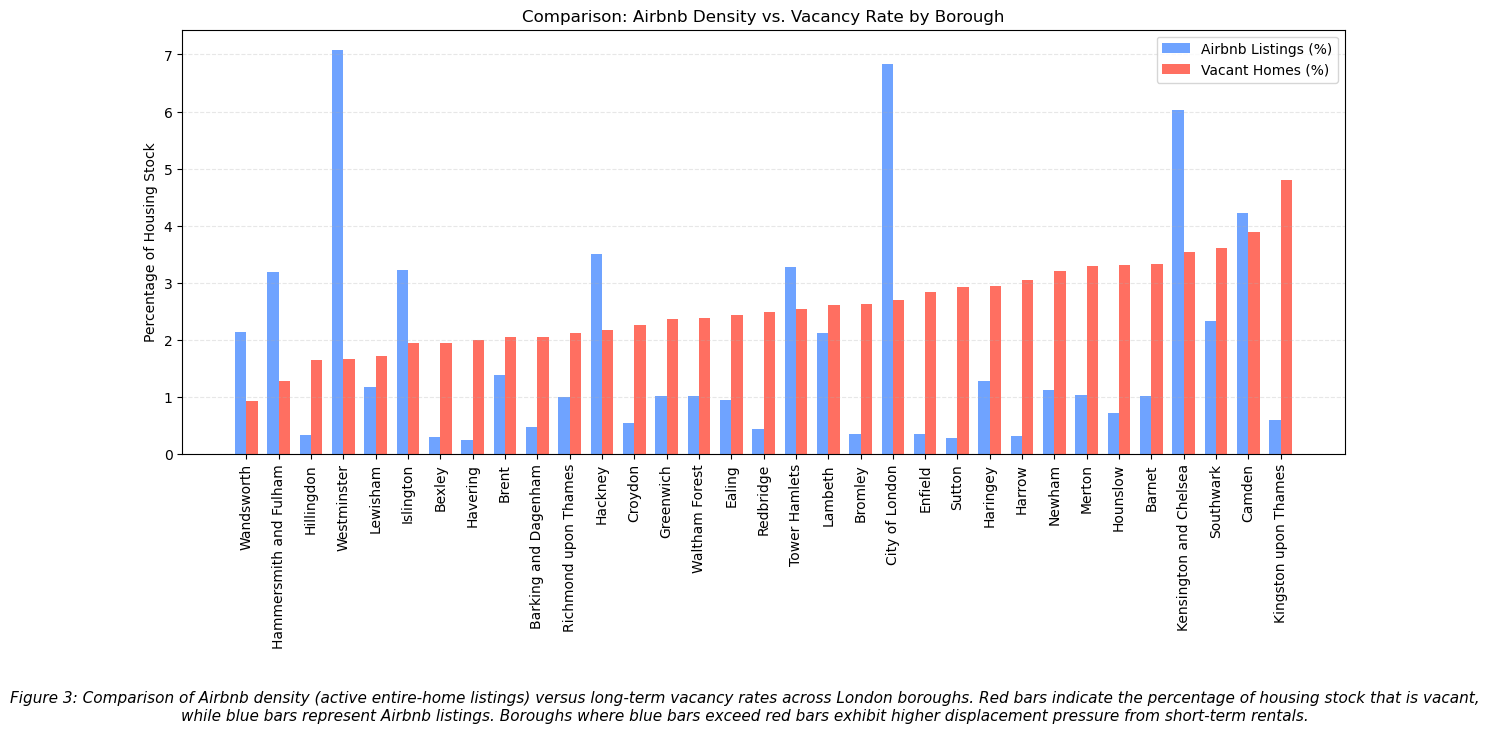

Top 5 Boroughs where Airbnb exceeds Vacancy (Ratio > 1):
                      NAME  rate_pct  vacant_rate_perc     Ratio
0              Westminster  7.082351          1.666253  4.250466
22          City of London  6.827803          2.690154  2.538071
9   Hammersmith and Fulham  3.186462          1.272432  2.504230
7               Wandsworth  2.138675          0.920468  2.323466
1   Kensington and Chelsea  6.019343          3.538087  1.701299


In [81]:
# Vacancy Rate
# --- 1. Load Data ---
ddir_2 = Path('data/airbnb')
spath_2 = 'https://raw.githubusercontent.com/JianlingZhao/fsds_Airbnb_dwelling_data/main/'
vacant = pd.read_csv( cache_data(spath_2 + 'vacant_local.csv', ddir_2) )
print('Done.')

# Clean Headers
dwl.columns = dwl.columns.str.strip()
vacant.columns = (
    vacant.columns.str.strip().str.lower()
    .str.replace(" ", "_").str.replace(r"[^a-z0-9_]", "", regex=True)
)

# Process Vacancy Data (Oct 2024)
target_col = '07102024'
if target_col in vacant.columns:
    vacant_24 = vacant[['ons_code', target_col]].copy()
else:
    vacant_24 = vacant.iloc[:, [0, -1]].copy()
vacant_24.columns = ['ons_code', 'vacant']

# Fix numbers (remove commas, handle '[x]')
vacant_24['vacant'] = pd.to_numeric(
    vacant_24['vacant'].astype(str).str.replace(',', ''), 
    errors='coerce'
).fillna(0).astype(int)

# Merge Vacancy + Dwelling
dwelling_stat = pd.merge(
    dwl, vacant_24, how='inner', 
    left_on=dwl.columns[0], right_on='ons_code'
)

# Rename Columns
dwelling_stat = dwelling_stat.rename(columns={
    dwl.columns[1]: 'Borough',
    dwl.columns[2]: 'Total_Dwellings'
})

# Calculate Vacancy Rate
dwelling_stat['vacant_rate_perc'] = (dwelling_stat['vacant'] / dwelling_stat['Total_Dwellings']) * 100


# Filter for Entire Homes
entire_home_df = df[df['room_type'] == 'Entire home/apt'].copy()
# Count listings per borough
airbnb_counts = entire_home_df['neighbourhood_cleansed'].value_counts().reset_index()
airbnb_counts.columns = ['NAME', 'count']

# We need GSS Codes to merge. 
boros_dwl_rate = airbnb_counts.merge(
    dwelling_stat[['Borough', 'Total_Dwellings', 'Lower tier local authorities Code']],
    left_on='NAME',
    right_on='Borough'
)
# Calculate Airbnb Rate
boros_dwl_rate['rate_pct'] = (boros_dwl_rate['count'] / boros_dwl_rate['Total_Dwellings']) * 100
boros_dwl_rate['GSS_CODE'] = boros_dwl_rate['Lower tier local authorities Code']

# --- 2. MERGE WITH AIRBNB DATA ---
# boros_dwl_rate should have columns: ['GSS_CODE', 'NAME', 'rate_pct']

# Merge vacancy rates into the Airbnb dataframe
cols_to_merge = ['Lower tier local authorities Code', 'vacant_rate_perc']

# Use inner join to ensure we only plot boroughs that exist in both datasets
boros_dwell_vac = boros_dwl_rate.merge(
    dwelling_stat[cols_to_merge],
    left_on='GSS_CODE',
    right_on='Lower tier local authorities Code',
    how='inner' 
)

# --- 3. GENERATE THE PLOT ---
# Sort by Vacancy Rate (Red bars) so the pattern is clear
df_sorted = boros_dwell_vac.sort_values('vacant_rate_perc', ascending=True)

# Set up positions for the bars
x = np.arange(len(df_sorted))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(15, 8))

# Plot Airbnb Bars (Blue)
rects1 = ax.bar(x - width/2, df_sorted['rate_pct'], width, label='Airbnb Listings (%)', color='#6FA3FF')

# Plot Vacancy Bars (Red)
rects2 = ax.bar(x + width/2, df_sorted['vacant_rate_perc'], width, label='Vacant Homes (%)', color='#FF6F61')

# Add Labels, Title, and Custom x-axis tick labels
ax.set_ylabel('Percentage of Housing Stock')
ax.set_title('Comparison: Airbnb Density vs. Vacancy Rate by Borough')
ax.set_xticks(x)
ax.set_xticklabels(df_sorted['NAME'], rotation=90)
ax.legend()

# Add a grid for easier reading
ax.grid(axis='y', linestyle='--', alpha=0.3)

caption_text = (
    "Figure 3: Comparison of Airbnb density (active entire-home listings) versus long-term vacancy rates across London boroughs. "
    "Red bars indicate the percentage of housing stock that is vacant, while blue bars represent Airbnb listings. "
    "Boroughs where blue bars exceed red bars exhibit higher displacement pressure from short-term rentals."
)

plt.subplots_adjust(bottom=0.35)

plt.figtext(0.5, 0.02, caption_text, wrap=True, horizontalalignment='center', fontsize=11, style='italic')

plt.show()

# --- 4. PRINT THE "OUT OF CONTROL" RATIO ---
boros_dwell_vac['Ratio'] = boros_dwell_vac['rate_pct'] / boros_dwell_vac['vacant_rate_perc']
print("Top 5 Boroughs where Airbnb exceeds Vacancy (Ratio > 1):")
print(boros_dwell_vac[['NAME', 'rate_pct', 'vacant_rate_perc', 'Ratio']].sort_values('Ratio', ascending=False).head())

In Figure 3, it further demonstrates that the situation of Airbnb in central London is not optimistic and reinforces our view that the platform is out of control in the city. In areas like **Westminster**, and **Kensington & Chelsea**, the number of active short-term rental properties (blue bars) has far exceeded the number of long-term vacant homes, while outer suburbs like **Croydon** and **Bakersley** follow the traditional pattern—long-term vacant homes (red bars) remain the primary source of unused housing.

This "crossover" effect refutes the notion that short-term rentals merely utilise surplus housing. Instead, it suggests that in the city’s most vibrant areas the tourism market consumes housing resources at a rate far exceeding the natural vacancy rate. When Airbnb listings are twice or more the number of vacant homes the platform ceases to be a passive participant in the housing market and becomes a primary driver of scarcity effectively removing far more homes from the long-term rental market than are actually vacant.

Airbnb Count Columns: ['Borough', 'Airbnb_Count']
Borough map loaded successfully.


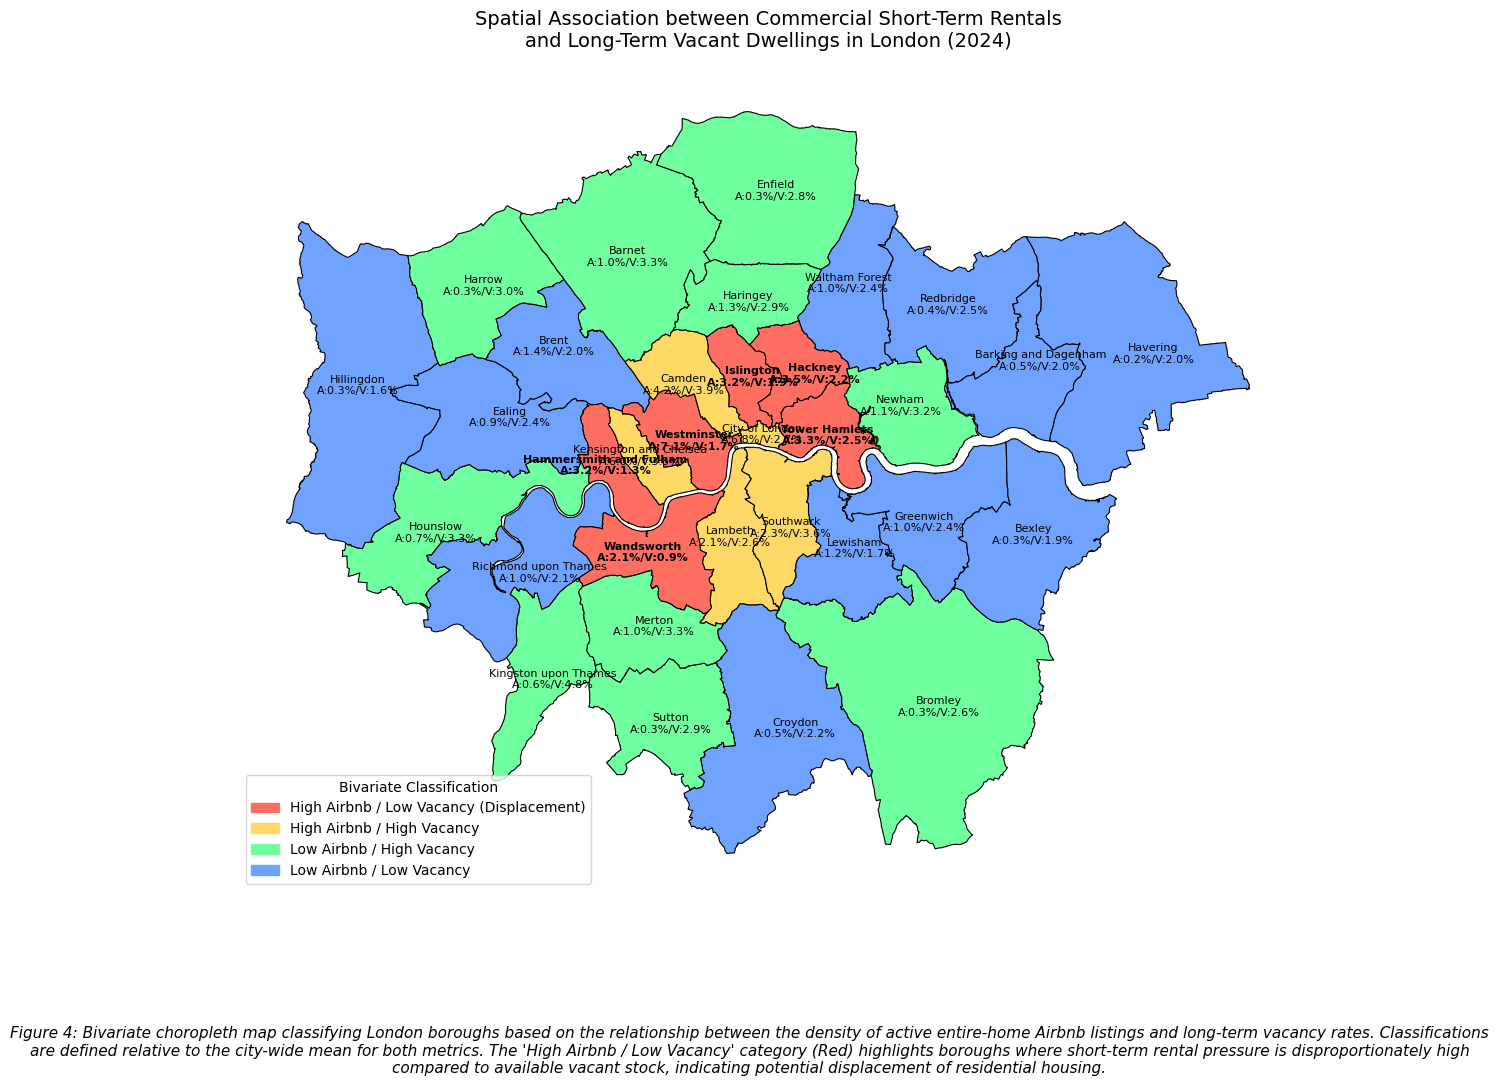

In [99]:
# Vacancy Map
# 1. PREPARE AIRBNB DATA (From gdf)
# ==========================================
# Filter for Entire Homes (Displacement impact)
# We assume your 'gdf' is already loaded as per your message
entire_homes = gdf[gdf['room_type'] == 'Entire home/apt'].copy()
# Count listings per borough
airbnb_counts = entire_homes['neighbourhood_cleansed'].value_counts().reset_index()

# FORCE rename columns to ensure match 
airbnb_counts.columns = ['Borough', 'Airbnb_Count']

print("Airbnb Count Columns:", airbnb_counts.columns.tolist())

# 2. PREPARE MAP GEOMETRY
geo_url = "https://raw.githubusercontent.com/westminsterDataStudio/open_data/main/boundary_files/boroughs_london.geojson"

try:
    boros_map = gpd.read_file(geo_url)
    print("Borough map loaded successfully.")
except Exception as e:
    print(f"Error loading map: {e}. Please ensure you have internet access or a local shapefile.")

# Merge Airbnb counts into the Map
# Now we are certain 'Borough' exists in airbnb_counts
boros_dwl_rate = boros_map.merge(
    airbnb_counts, 
    left_on='NAME', 
    right_on='Borough', 
    how='left'
)
# Fill NaNs with 0 (for boroughs with no listings)
boros_dwl_rate['Airbnb_Count'] = boros_dwl_rate['Airbnb_Count'].fillna(0)

# ==========================================
# 3. MERGE WITH VACANCY DATA
# ==========================================
# (Assuming 'dwelling_stat' exists from previous steps. 
# If not, please re-run the vacancy loading code provided earlier)

# Merge Vacancy Stats into the Map
boros_dwell_vac = boros_dwl_rate.merge(
    dwelling_stat[['Lower tier local authorities Code', 'Total_Dwellings', 'vacant_rate_perc']],
    left_on='GSS_CODE', 
    right_on='Lower tier local authorities Code',
    how='inner'
)

# Calculate Airbnb Rate %
boros_dwell_vac['rate_pct'] = (boros_dwell_vac['Airbnb_Count'] / boros_dwell_vac['Total_Dwellings']) * 100

# ==========================================
# 4. CLASSIFY & PLOT (Figure 4)
# ==========================================
# Define Thresholds
airbnb_mean = boros_dwell_vac['rate_pct'].mean()
vacant_mean = boros_dwell_vac['vacant_rate_perc'].mean()

def classify(row):
    if row['rate_pct'] >= airbnb_mean and row['vacant_rate_perc'] >= vacant_mean:
        return 'HH' # High Airbnb, High Vacancy
    elif row['rate_pct'] < airbnb_mean and row['vacant_rate_perc'] < vacant_mean:
        return 'LL' # Low Airbnb, Low Vacancy
    elif row['rate_pct'] >= airbnb_mean and row['vacant_rate_perc'] < vacant_mean:
        return 'HL' # High Airbnb, Low Vacancy (Displacement Zone)
    else:
        return 'LH' # Low Airbnb, High Vacancy

boros_dwell_vac['combo_class'] = boros_dwell_vac.apply(classify, axis=1)

# Colors
color_dict = {
    'HH': '#FFD966',  # Yellow
    'LL': '#6FA3FF',  # Blue
    'HL': '#FF6F61',  # Red
    'LH': '#6FFF9E',  # Green
}
boros_dwell_vac['color'] = boros_dwell_vac['combo_class'].map(color_dict)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
boros_dwell_vac.plot(color=boros_dwell_vac['color'], edgecolor='black', linewidth=0.8, ax=ax)

# Annotate
for idx, row in boros_dwell_vac.iterrows():
    x, y = row['geometry'].representative_point().x, row['geometry'].representative_point().y
    label = f"{row['NAME']}\nA:{row['rate_pct']:.1f}%/V:{row['vacant_rate_perc']:.1f}%"
    font_weight = 'bold' if row['combo_class'] == 'HL' else 'normal'
    ax.text(x, y, label, ha='center', va='center', fontsize=8, color='black', fontweight=font_weight)

# Legend
patches = [
    mpatches.Patch(color=color_dict['HL'], label='High Airbnb / Low Vacancy (Displacement)'),
    mpatches.Patch(color=color_dict['HH'], label='High Airbnb / High Vacancy'),
    mpatches.Patch(color=color_dict['LH'], label='Low Airbnb / High Vacancy'),
    mpatches.Patch(color=color_dict['LL'], label='Low Airbnb / Low Vacancy')
]
ax.legend(handles=patches, title='Bivariate Classification', loc='lower left')

plt.title('Spatial Association between Commercial Short-Term Rentals\nand Long-Term Vacant Dwellings in London (2024)', fontsize=14, pad=20)
plt.axis('off')

caption_text = (
    "Figure 4: Bivariate choropleth map classifying London boroughs based on the relationship between the density of active "
    "entire-home Airbnb listings and long-term vacancy rates. Classifications are defined relative to the city-wide mean "
    "for both metrics. The 'High Airbnb / Low Vacancy' category (Red) highlights boroughs where short-term rental pressure "
    "is disproportionately high compared to available vacant stock, indicating potential displacement of residential housing."
)

# Adjust layout and place caption
plt.subplots_adjust(bottom=0.20)
plt.figtext(0.5, 0.05, caption_text, wrap=True, horizontalalignment='center', fontsize=11, style='italic')

plt.show()

Figure 4 illustrates the distribution of housing pressure in London, revealing a significant disparity between the city centre and the suburbs.

The map highlights a concentration of boroughs in central London such as Westminster and Kensington & Chelsea marked in red. These areas are characterised by a high number of Airbnb listings and low vacancy rates. This suggests that the housing shortage in the city centre is not caused by vacant properties but rather by residential homes being converted into tourist accommodations.

In contrast, the green areas in the outer suburbs indicate a more traditional pattern: there are high long-term vacancy rates but minimal Airbnb activity. This map demonstrates that the ‘Airbnb crisis’ is not a citywide phenomenon but rather a localised issue confined to the city centre where the platform is competing with residents for scarce housing resources.

#### Limitations

Vacancy data from the rental market is not available, so the vacancy rate is calculated based on all dwellings, not just those available for rental. Some vacant homes may be owner-occupied or otherwise unavailable for renting, so the measure is an approximation, so as Airbnb ratio. Other factors affecting housing availability or Airbnb distribution (e.g., local regulations, rental demand, property prices) are not included in this part.
The dwelling stock data are from 2021, which could cause slight deviations. However, changes in total housing stock over time are relatively modest, so these changes are expected to have minimal impact on the findings.

### Question 2: Professional Landlords

#### Definition of Professional Landlords

Since the opposition proposal focusses on "professional landlords" it is crucial that how we define this group of hosts. As Boto-García (2025, p.6) defined, "professional hosts are profit-oriented players who behave similarly to business corporations while non-professional hosts primarily engage in sharing-oriented supply". The distinction between the two is generally based on the number of accommodations offered and the type of rooms provided. 

Therefore, we take a further exploration of each room type.

1. **Entire home/apt** and **Hotel room** have high likelihood of professionalism, because these mean their hosts are renting out an entire, separate unit. It is more straghtforward to the host of a Hotel room. If a host has multiple "Entire home/apt" listings, they are almost certainly a professional operator, as they are not living in any of the units and are solely focused on commercial rental income.

2. **Private room** has lower likelihood (usually). This often implies a host lives on-site and is renting out a spare bedroom, which is closer to the original, non-commercial ethos of Airbnb. While some professional operators manage multiple private rooms within a single large property, the classification itself is a much softer signal than "Entire home/apt." We will explore this case later in this section.

3. **Shared room** can be regarded as hostel/budget operator. This usually indicates a commercial hostel or a very budget-focused operator.


Since single-room landlords with "Private" and "Shared" rooms perfectly align with the concept of the "sharing economy", they are directly excluded from the "professional landlords" category. Therefore, our criteria for a **"Professional Landlord"** must satisfy Criterion 1 (Scale) with a threshold of  `listing_count` $\geq 1$ AND its `room_type` must be one of the types selected by Criterion 2 (Intent), which is either ‘Entire home/apt’ or ‘Hotel room’.





In [ ]:
#### Strategy

# 1. Group_by `host_id`
# 2. Sum the count of listings manually
# 3. Compare the sum result with `calculated_host_listings_count` to check the accuracy
# 4. Filter by `room_type`
# 5. Use `calculated_host_listings_count` and `room_type` as criteria columns to lock professional landlords.

In [19]:
# accuracy of column `calculated_host_listings_count`

# group by `host_id`
df['listing_count'] = df.groupby('host_id')['id'].transform('count')
## Filter df to keep only hosts with 2 or more listings
df_multi_host = df[df['listing_count'] > 1].copy()

## Filter df to keep hosts with one listing
df_single_host = df[df['listing_count'] == 1].copy()
col_landlord = ['host_id', 'id', 'room_type', 'property_type', 'listing_count', 
                'calculated_host_listings_count', 'description']
df_multi_host = df_multi_host[col_landlord]
df_single_host = df_single_host[col_landlord]

df_multi_host['is_match'] = df_multi_host['listing_count'] == df_multi_host['calculated_host_listings_count']
num_matches = df_multi_host['is_match'].sum()
total_length = len(df_multi_host)
num_mismatches = total_length - num_matches
print(f"Number of mismatches (discrepancies) in multi-listing hosts: {num_mismatches:,}")
df_single_host['is_match'] = df_single_host['listing_count'] == df_single_host['calculated_host_listings_count']
num_matches = df_single_host['is_match'].sum()
total_length = len(df_single_host)
num_mismatches = total_length - num_matches
print(f"Number of mismatches (discrepancies) in single-listing hosts: {num_mismatches:,}")

Number of mismatches (discrepancies) in multi-listing hosts: 0
Number of mismatches (discrepancies) in single-listing hosts: 0


In [ ]:
# Then using the column `calculated_host_listings_count`, we can filter the `room_type` (and `property_type`) for further analysis. 
# The `room_type` column directly addresses the commercial intent by defining the relationship between the host and the listing.

Our analysis is below:

1. **Entire home/apt** and **Hotel room** have high likelihood of professionalism, because these mean their hosts are renting out an entire, separate unit. It is more straghtforward to the host of a Hotel room. If a host has multiple "Entire home/apt" listings, they are almost certainly a professional operator, as they are not living in any of the units and are solely focused on commercial rental income.

2. **Private room** has lower likelihood (usually). This often implies a host lives on-site and is renting out a spare bedroom, which is closer to the original, non-commercial ethos of Airbnb. While some professional operators manage multiple private rooms within a single large property, the classification itself is a much softer signal than "Entire home/apt." We will explore this case later in this section.

3. **Shared room** can be regarded as hostel/budget operator. This usually indicates a commercial hostel or a very budget-focused operator.

Since single-room landlords with "Private" and "Shared" rooms perfectly align with the concept of the "sharing economy", they are directly excluded from the "professional landlords" category. Therefore, our criteria for a **"Professional Landlord"** must satisfy Criterion 1 (Scale) with a threshold of  `listing_count` $\geq 1$ AND its `room_type` must be one of the types selected by Criterion 2 (Intent), which is either ‘Entire home/apt’ or ‘Hotel room’.

--- 1. Professional Landlord Analysis ---
Total Unique Landlords: 55,804
Total number of Professional Landlords (Unique Host IDs): 35,953
Total number of Properties managed by these landlords: 62,567
Percentage of Professional Landlords: 64.43%
Percentage of Professional Properties: 64.73%

--- 2. Segmentation Summary ---
Total Multi-Host Listings (df_multi_host): 51,675
Total Single-Host Listings (df_single_host): 44,976


<Figure size 1000x600 with 0 Axes>

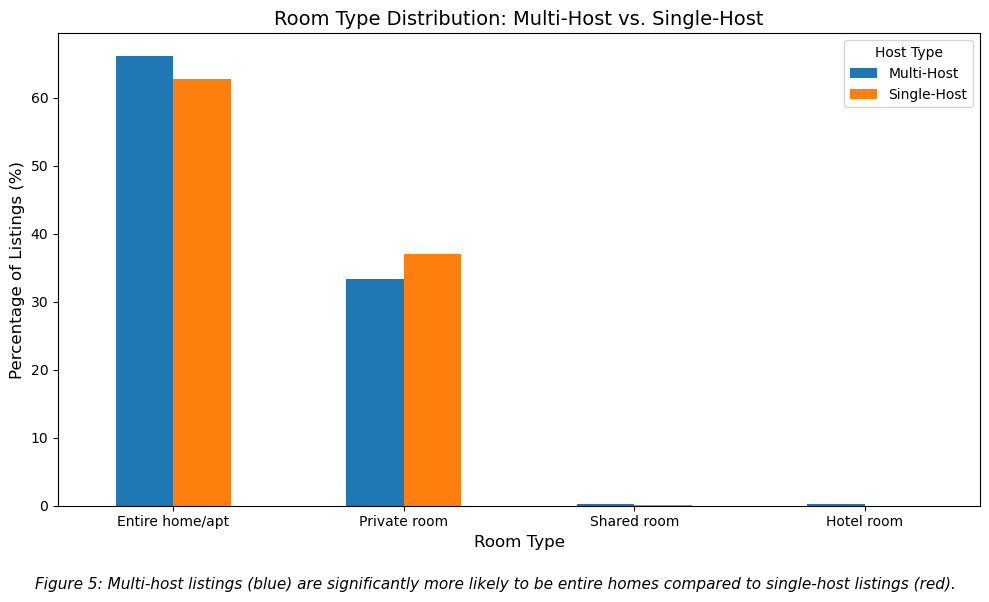


--- 3. Distribution Comparison (Percentage) ---
                 Multi-Host  Single-Host
room_type                               
Entire home/apt   66.194485    62.811277
Private room      33.312046    37.084223
Shared room        0.294146     0.086713
Hotel room         0.199323     0.017787


In [107]:
# Define the columns we'll be interested in throughout the analysis
COLUMNS_OF_INTEREST = [
    'host_id', 'id', 'room_type', 'property_type', 'calculated_host_listings_count'
]

## --- STAGE 1: CLASSIFICATION AND SEGMENTATION ---

# 1. Define the Professional Landlord Criteria (Intent and Scale)
is_entire_multi = (df['room_type'] == 'Entire home/apt') & (df['calculated_host_listings_count'] >= 1)
is_hotel = (df['room_type'] == 'Hotel room')
df['is_professional_listing'] = is_entire_multi | is_hotel


# --- 1.1. Create the Final Professional Landlord DF (df_landlord) ---

# Filter the main DF to keep ONLY the professional listings and select columns
df_professional = df[df['is_professional_listing']].copy()
df_landlord = df_professional[COLUMNS_OF_INTEREST]

# --- 1.2. Create Multi/Single Host DFs for Distribution Analysis ---

# Filter for Multi-Host Listings (Scale > 1)
df_multi_host = df[df['calculated_host_listings_count'] > 1].copy()
df_multi_host = df_multi_host[COLUMNS_OF_INTEREST]

# Filter for Single-Host Listings (Scale = 1)
df_single_host = df[df['calculated_host_listings_count'] == 1].copy()
df_single_host = df_single_host[COLUMNS_OF_INTEREST]


# --- STAGE 2: CALCULATION AND ANALYSIS ---

total_landlords = df['host_id'].nunique()
total_property = df.shape[0]

# 3. Final Calculation for Professional Landlords
num_professional_landlords = df_landlord['host_id'].nunique()
num_properties = df_landlord.shape[0]

if total_landlords > 0:
    professional_percentage = (num_professional_landlords / total_landlords) * 100
else:
    professional_percentage = 0.0

pro_property_percentage = (num_properties / total_property)*100

print("--- 1. Professional Landlord Analysis ---")
print(f"Total Unique Landlords: {total_landlords:,}")
print(f"Total number of Professional Landlords (Unique Host IDs): {num_professional_landlords:,}")
print(f"Total number of Properties managed by these landlords: {num_properties:,}")
print(f"Percentage of Professional Landlords: {professional_percentage:.2f}%")
print(f"Percentage of Professional Properties: {pro_property_percentage:.2f}%")

print("\n--- 2. Segmentation Summary ---")
print(f"Total Multi-Host Listings (df_multi_host): {df_multi_host.shape[0]:,}")
print(f"Total Single-Host Listings (df_single_host): {df_single_host.shape[0]:,}")


# --- STAGE 3: VISUALIZATION (Distribution Comparison) ---

# 4. Calculate the distribution for each group
multi_host_distribution = df_multi_host['room_type'].value_counts(normalize=True) * 100
single_host_distribution = df_single_host['room_type'].value_counts(normalize=True) * 100

# 5. Combine the distributions for plotting
comparison_df = pd.DataFrame({
    'Multi-Host': multi_host_distribution,
    'Single-Host': single_host_distribution
}).fillna(0)

# 6. Plot the side-by-side comparison
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar', figsize=(10, 6))

plt.title('Room Type Distribution: Multi-Host vs. Single-Host', fontsize=14)
plt.ylabel('Percentage of Listings (%)', fontsize=12)
plt.xlabel('Room Type', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Host Type')
caption_text = "Figure 5: Multi-host listings (blue) are significantly more likely to be entire homes compared to single-host listings (red)."
plt.figtext(0.5, 0.01, caption_text, wrap=True, horizontalalignment='center', fontsize=11, style='italic')

plt.tight_layout(rect=[0, 0.05, 1, 1]) # Reserve space for caption
plt.savefig('room_type_comparison_figure_6.png', dpi=300)
plt.show() 

print("\n--- 3. Distribution Comparison (Percentage) ---")
print(comparison_df)

Based on our criteria of "Professional Landlord", there are 35,953 of them, which is 64.43% of the whole number of hosts. This can also be viewed as a further evidence showing Airbnb is "out of control" in London.

##### Limitation:

Multi-room landlords offering "Private" or "Shared" rooms were not categorised as "professional landlords" because their listing descriptions lacked significant textual similarity to the professional standards applied in ‘whole house’ and "Hotel" listings. This is a minor limitation as shared and private rooms represent a relatively smaller proportion of all listings (approximately 33%). Therefore, excluding this segment does not significantly alter our main conclusions regarding professional landlord behaviour.

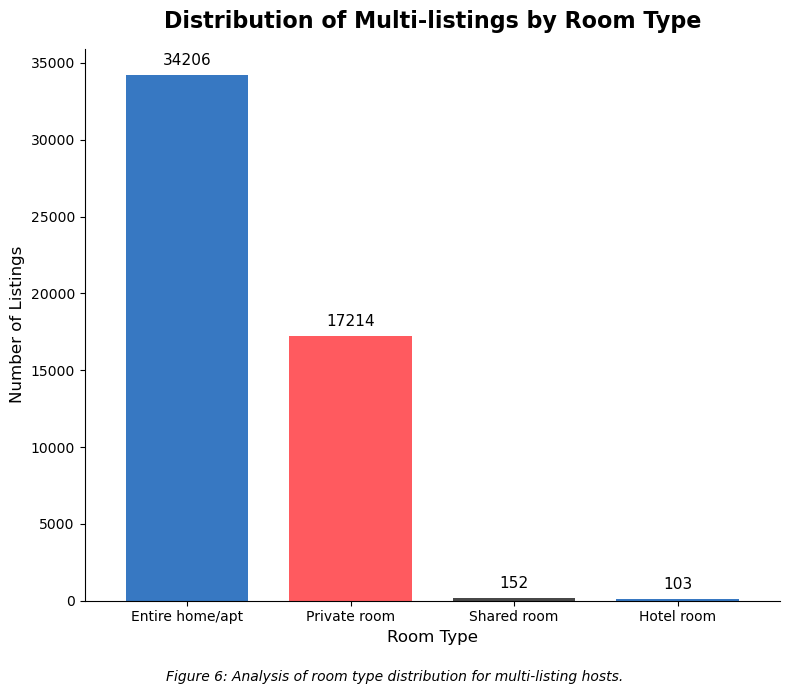

--- Room Type Distribution for Multi-Listing Landlords ---

1. Raw Counts:
room_type
Entire home/apt    34206
Private room       17214
Shared room          152
Hotel room           103
Name: count, dtype: int64

2. Percentage Distribution:
room_type
Entire home/apt    66.19%
Private room       33.31%
Shared room         0.29%
Hotel room           0.2%
Name: proportion, dtype: object


In [105]:
# multi-listing host
room_type_counts = df_multi_host['room_type'].value_counts()

# --- SECTION 2: PLOTTING ---
# Initialize figure (slightly taller to accommodate the bottom caption)
plt.figure(figsize=(8, 7))

# Create the bar chart
ax = room_type_counts.sort_values(ascending=False).plot(
    kind='bar', 
    color=['#3778c2', '#ff5a5f', '#484848'], 
    width=0.75
)

# --- SECTION 3: STYLING & LABELS ---
# Title and Axis Labels
plt.title('Distribution of Multi-listings by Room Type', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)

# Fix X-axis rotation (0 is usually better for these short labels)
plt.xticks(rotation=0, ha='center')

# Clean up borders (remove top and right spines for a modern look)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add data labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=11)

# --- SECTION 4: CAPTION (FIGURE 5) ---
# Add the caption at the bottom of the figure
caption_text = "Figure 6: Analysis of room type distribution for multi-listing hosts."
plt.figtext(0.5, 0.02, caption_text, wrap=True, horizontalalignment='center', fontsize=10, style='italic')

# Adjust layout to ensure the caption isn't cut off
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Save and Show
plt.savefig('room_type_distribution_figure_5.png', dpi=300)
plt.show()

# --- SECTION 5: PRINT STATISTICS ---
# Calculate percentages
room_type_percentages = df_multi_host['room_type'].value_counts(normalize=True) * 100

print("--- Room Type Distribution for Multi-Listing Landlords ---")
print("\n1. Raw Counts:")
print(room_type_counts)
print("\n2. Percentage Distribution:")
print(room_type_percentages.round(2).astype(str) + '%')